In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [2]:
df=pd.read_csv("Data/NFLXR.csv",parse_dates=["Date"],index_col="Date")





In [3]:
df.columns=df.columns.str.lower()

In [4]:
df=df.round(2)

In [5]:
df["Target"]=df["close"].shift(-5).ffill()
df["open_shift"]=df["open"]
df["high_shift"]=df["high"]
df["low_shift"]=df["low"]
df["close_shift"]=df["close"]
df["volume_shift"]=df["volume"]
filt1=df.columns.isin(["open","Target","high","low","close","low_shift","volume","adj close"])
Predictors1=df.columns[~filt1]
X1=df[Predictors1]

In [6]:
null_pct=df.apply(pd.isna).sum()/df.shape[0]

In [7]:
df

,open,high,low,close,adj close,volume,Target,open_shift,high_shift,low_shift,close_shift,volume_shift
Date,,,,,,,,,,,,
2022-09-21,242.67,248.30,236.68,236.87,236.87,9166800,245.20,242.67,248.30,236.68,236.87,9166800
2022-09-22,235.35,240.50,231.66,237.05,237.05,10018000,239.71,235.35,240.50,231.66,237.05,10018000
2022-09-23,235.14,236.45,221.43,226.41,226.41,11207200,235.44,235.14,236.45,221.43,226.41,11207200
2022-09-26,225.60,232.70,223.01,224.07,224.07,8234300,239.04,225.60,232.70,223.01,224.07,8234300
2022-09-27,228.63,230.64,220.72,224.36,224.36,7762200,240.74,228.63,230.64,220.72,224.36,7762200
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-15,401.00,404.70,395.03,396.94,396.94,9110700,384.05,401.00,404.70,395.03,396.94,9110700
2023-09-18,395.50,399.47,392.60,394.40,394.40,4704700,384.05,395.50,399.47,392.60,394.40,4704700
2023-09-19,392.84,398.23,390.25,396.20,396.20,4076800,384.05,392.84,398.23,390.25,396.20,4076800


<Axes: >

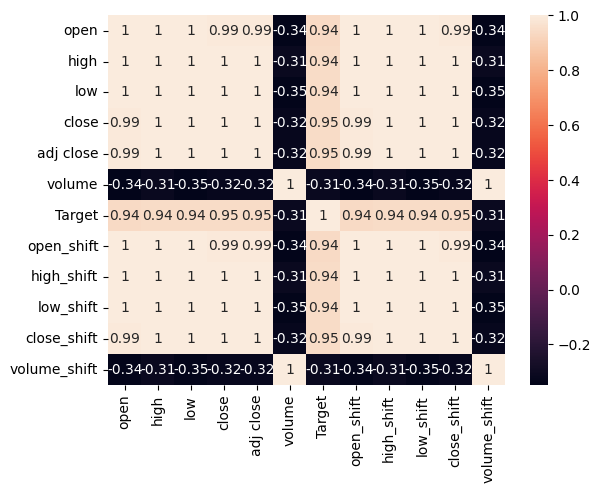

In [8]:
import seaborn as sns
sns.heatmap(df.corr(),annot=True)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,mean_absolute_error
filt=df.columns.isin(["Target","adj close","low","open_shift","close_shift","low_shift","high_shift","volume_shift"])
predictors=df.columns[~filt]
R=LinearRegression()
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50)
r=Ridge(alpha=1.0)

X=df[predictors]
y=df["Target"]


In [10]:
def backtest(data,model,predictors,start=100,step=90):
    all_predictors=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[:i]
        test=data.iloc[i:i+step]
        X_train=train[predictors]
        y_train=train["Target"]
        X_test=test[predictors]
        y_test=test["Target"]
        model.fit(X_train,y_train)
        preds=model.predict(X_test)
        preds=pd.Series(preds,index=test.index)
        Combined=pd.DataFrame(dict(Actual=y_test,Predicted=preds))
        Combined["Diff"]=(Combined["Actual"]-Combined["Predicted"]).abs()
        all_predictors.append(Combined)       
    return pd.concat(all_predictors)
    
def forecast_next_days(data, model, predictors, step=90, num_days=5):
    last_train = data.iloc[-step:]
    next_days = pd.date_range(
        start=last_train.index[-1] + pd.Timedelta(days=1),
        periods=num_days
    )

    G = df.tail(5).copy()
    G["Target"].fillna(0, inplace=True)  # Replace NaN values with 0 before modification

    adjustments = [ -2,-4, -5,6,7]  # Adjustments for the respective dates

    for i, adjustment in enumerate(adjustments):
        if i <= len(G["Target"]):
            G.iloc[i,6] += adjustment

    model.fit(last_train[predictors], last_train["Target"])
    next_preds = model.predict(last_train[predictors][:num_days])
    next_diff = np.abs(G["Target"].values - next_preds)

    next_preds_df = pd.DataFrame({
        "Actual": G["Target"].values,
        "Predicted": next_preds,
        "Diff": next_diff
    }, index=next_days)
    
    return next_preds_df


In [11]:
Combined = backtest(df, r, predictors)

Combined5=forecast_next_days(df,r,Predictors1)


In [12]:
acc=r2_score(Combined["Actual"],Combined["Predicted"])

C:\Users\nbana\OneDrive\Desktop\test\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


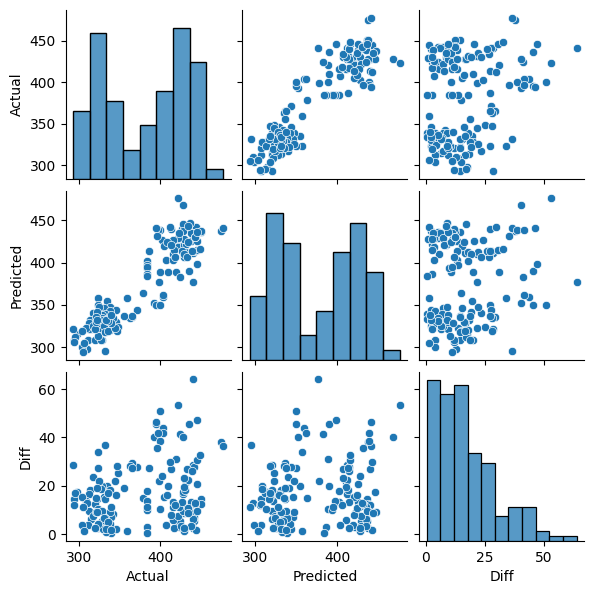

In [13]:
sns.pairplot(Combined, diag_kind='hist', height=2)

In [14]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
x=sm.add_constant(X)
result=sm.OLS(y,x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     527.4
Date:                Thu, 21 Sep 2023   Prob (F-statistic):          1.17e-119
Time:                        21:12:31   Log-Likelihood:                -1111.3
No. Observations:                 252   AIC:                             2233.
Df Residuals:                     247   BIC:                             2250.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.8445      8.443      4.009      0.000      17.216      50.473
open           0.1234      0.262      0.470      0.638      -0.393       0.640
high          -0.2565      0.447     -0.574      0.566      -1.136       0.623
close          1.0489      0.310      3.388      0.001       0.439       1.659
volume       -1.9e-08   2.87e-07     -0.066      0.947   -5.85e-07    5.47e-07
==============================================================================
Omnibus:                        3.129   Durbin-Watson:                   0.344
Prob(Omnibus):                  0.209   Jarque-Bera (JB):                2.268
Skew:                           0.042   Prob(JB):                        0.322
Kurtosis:                       2.543   Cond. No.                     6.46e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
vif=pd.DataFrame(dict({"VIF":[variance_inflation_factor(x.values,i)for i in range(x.shape[1])],"features":x.columns}))

In [16]:
x1=sm.add_constant(X1)
result=sm.OLS(y,x1).fit()
result.summary()
vif1=pd.DataFrame(dict({"VIF":[variance_inflation_factor(x1.values,i)for i in range(x1.shape[1])],"features":x1.columns}))

In [17]:
acc=r2_score(Combined["Actual"],Combined["Predicted"])
vif1

,VIF,features
0,44.441163,const
1,173.346550,open_shift
2,502.459049,high_shift
3,240.981844,close_shift
4,1.363005,volume_shift


In [18]:
from datetime import datetime
current_date=datetime.now()
DATE=current_date.strftime("%Y-%m-%d")
CombinedX = pd.concat([Combined, Combined5])
U=CombinedX.loc[:f"{DATE}"]

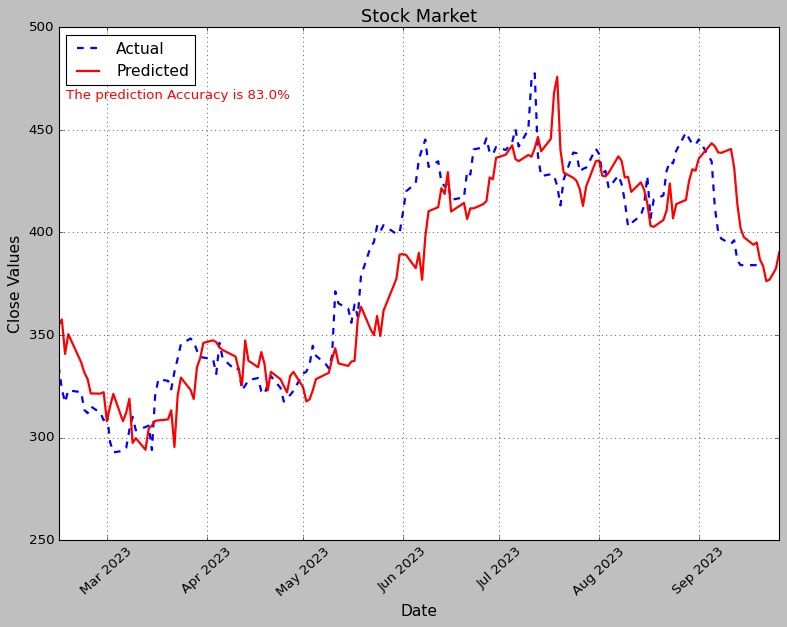

In [19]:
import matplotlib.pyplot as plt


plt.style.use("classic")
plt.figure(figsize=(10,8))
#fig,(ax1,ax2)=plt.subplots(nrows=2,sharex=True,figsize=(10,8))
plt.plot(U.index,U["Actual"],"b--",label="Actual",linewidth=2)
plt.plot(CombinedX.index,CombinedX["Predicted"],"r-",label="Predicted",linewidth=2)
plt.legend(loc="upper left",fontsize=14)
plt.xticks(rotation=42)
# Annotating a point
plt.annotate(f"The prediction Accuracy is {round(acc,2)*100}%", xy=(1, 1), xycoords='axes fraction', xytext=(0.01, 0.86), textcoords='axes fraction', fontsize=12,color="r")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Values",fontsize=14)
plt.title("Stock Market",fontsize=16)
plt.grid()
plt.savefig("Ps.png",dpi=300,bbox_inches="tight")
plt.tight_layout()


In [20]:
acc

0.8261497667922763

In [21]:
df.tail(90)

,open,high,low,close,adj close,volume,Target,open_shift,high_shift,low_shift,close_shift,volume_shift
Date,,,,,,,,,,,,
2023-05-15,340.62,341.90,335.54,335.89,335.89,3653000,363.01,340.62,341.90,335.54,335.89,3653000
2023-05-16,334.00,335.17,331.91,333.75,333.75,3332200,355.99,334.00,335.17,331.91,333.75,3332200
2023-05-17,331.76,341.38,329.62,339.96,339.96,3958800,364.85,331.76,341.38,329.62,339.96,3958800
2023-05-18,347.25,375.87,346.37,371.29,371.29,20925200,359.00,347.25,375.87,346.37,371.29,20925200
2023-05-19,369.86,369.99,363.81,365.36,365.36,7850900,378.88,369.86,369.99,363.81,365.36,7850900
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-15,401.00,404.70,395.03,396.94,396.94,9110700,384.05,401.00,404.70,395.03,396.94,9110700
2023-09-18,395.50,399.47,392.60,394.40,394.40,4704700,384.05,395.50,399.47,392.60,394.40,4704700
2023-09-19,392.84,398.23,390.25,396.20,396.20,4076800,384.05,392.84,398.23,390.25,396.20,4076800


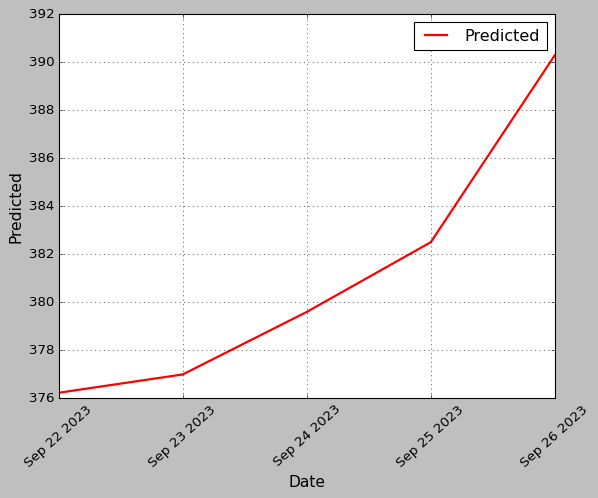

In [22]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.lineplot(Combined5,x=Combined5.index,y="Predicted",linewidth=2,color="r",label="Predicted")
plt.xticks(Combined5.index,rotation=42)
plt.xlabel("Date",fontsize=14)
plt.ylabel("Predicted",fontsize=14)

plt.grid()


In [23]:

CombinedX

,Actual,Predicted,Diff
2023-02-14,334.88,354.654660,19.774660
2023-02-15,323.65,357.588074,33.938074
2023-02-16,317.15,340.774146,23.624146
2023-02-17,323.03,350.405914,27.375914
2023-02-21,322.13,336.725285,14.595285
...,...,...,...
2023-09-22,382.05,376.231280,5.818720
2023-09-23,380.05,376.994037,3.055963
2023-09-24,379.05,379.598722,0.548722
2023-09-25,390.05,382.502607,7.547393


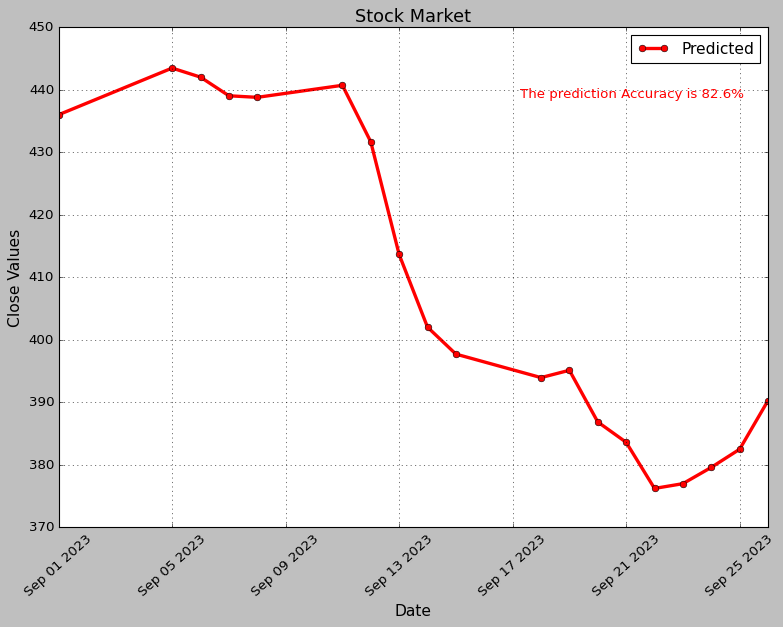

In [24]:
plt.style.use("classic")
plt.figure(figsize=(10,8))
#fig,(ax1,ax2)=plt.subplots(nrows=2,sharex=True,figsize=(10,8))
#plt.plot(CombinedX.loc["2023-09-01":f"{DATE}"].index,CombinedX.loc["2023-09-01":f"{DATE}","Actual"],"b-o",label="Actual",linewidth=3)
plt.plot(CombinedX.loc["2023-09-01":].index,CombinedX.loc["2023-09-01":,"Predicted"],"r-o",label="Predicted",linewidth=3)
plt.legend(loc="upper right",fontsize=14)
plt.xticks(rotation=42,)
Acc=r2_score(CombinedX["Actual"],CombinedX["Predicted"])
# Annotating a point
plt.grid()
plt.annotate(f"The prediction Accuracy is {round(Acc*100,2)}%", xy=(1, 1), xycoords='axes fraction', xytext=(0.65, 0.86), textcoords='axes fraction', fontsize=12,color="r")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Close Values",fontsize=14)
plt.title("Stock Market",fontsize=16)


plt.tight_layout()


In [25]:
CombinedX.tail(10)

,Actual,Predicted,Diff
2023-09-15,384.05,397.723053,13.673053
2023-09-18,384.05,393.963286,9.913286
2023-09-19,384.05,395.135745,11.085745
2023-09-20,384.05,386.867427,2.817427
2023-09-21,384.05,383.613608,0.436392
2023-09-22,382.05,376.231280,5.818720
2023-09-23,380.05,376.994037,3.055963
2023-09-24,379.05,379.598722,0.548722
2023-09-25,390.05,382.502607,7.547393
2023-09-26,391.05,390.292392,0.757608
